In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib import colormaps
import os, shutil
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.double)

from botorch.utils.transforms import normalize

from activephasemap.np.neural_process import NeuralProcess
from activephasemap.utils.settings import initialize_model
from activephasemap.test_functions.phasemaps import SimulatorTestFunction
from activephasemap.test_functions.phasemaps import ExperimentalTestFunction
from activephasemap.utils.simulators import UVVisExperiment

pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight',
               
              } 

In [4]:
ITERATION = 2
DATA_DIR = "./"
design_space_bounds = [(0.0, 87.0), (0.0,11.0)]

expt = UVVisExperiment(ITERATION, DATA_DIR+"/data/")
expt.generate()
test_function = ExperimentalTestFunction(sim=expt, bounds=design_space_bounds)
gp_model_args = {"model":"gp", "num_epochs" : 1, "learning_rate" : 1e-3, "verbose": 1}
np_model_args = {"num_iterations": 1, "verbose":True, "print_freq":100, "lr":5e-4}
input_dim = test_function.dim
output_dim = 2 

# Load trained GP model for p(z|c)
gp_model = initialize_model(gp_model_args, input_dim, output_dim, device)
train_x = torch.load(DATA_DIR+'/output/train_x_%d.pt'%ITERATION, map_location=device)
train_y = torch.load(DATA_DIR+'/output/train_y_%d.pt'%ITERATION, map_location=device)
bounds = test_function.bounds.to(device)
normalized_x = normalize(train_x, bounds).to(train_x)
gp_state_dict = torch.load(DATA_DIR+'/output/gp_model_%d.pt'%(ITERATION), map_location=device)
loss = gp_model.fit(normalized_x, train_y)
print("GP Model loss : ", loss)
gp_model.load_state_dict(gp_state_dict)

# Load trained NP model for p(y|z)
np_model = NeuralProcess(1, 1, 128, 2, 128).to(device)
np_model.load_state_dict(torch.load(DATA_DIR+'/output/np_model_%d.pt'%(ITERATION), map_location=device))

Loading data from iteration 0 with shapes: (24, 2) (24, 101)
Loading data from iteration 1 with shapes: (8, 2) (8, 101)
GP Model loss :  [1.3818827993933462]


<All keys matched successfully>

### Plot few samples from Nueral Process Model

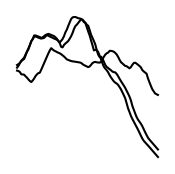

In [5]:
x_target = torch.Tensor(np.linspace(0, 1, 100)).to(device)
x_target = x_target.unsqueeze(1).unsqueeze(0)

with torch.no_grad(), plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(2,2))
    z_sample = torch.randn((3, 2)).to(device)
    for i in range(3):
        mu, _ = np_model.xz_to_y(x_target, z_sample[i,:])
        ax.plot(x_target.cpu().numpy()[0], mu.cpu().numpy()[0], color='k')
        ax.locator_params(tight=True, nbins=4)
        ax.axis('off')
    plt.show()

### Plot phase map as predicted by the trained model
This requires us to pass composition to a GP model which predicts latent variables `z_pred`. The predicted `z_pred` are used to inturn sample a curve that is representative of the spectroscopic measurement at given composition.

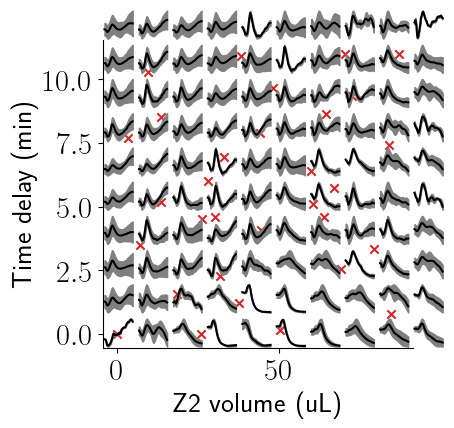

In [19]:
from activephasemap.utils.visuals import plot_gpmodel_grid 

with torch.no_grad(), plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(4,4))
    x_ = test_function.sim.comps
    plot_gpmodel_grid(ax, test_function, gp_model, np_model,
                      num_grid_spacing=10, color='k', 
                      show_sigma=True, scale_axis=False
                      )
    ax.scatter(x_[:,0], x_[:,1], marker='x', color='tab:red')
    ax.set_xlabel('Z2 volume (uL)')
    ax.set_ylabel('Time delay (min)') 

    plt.show()

### Plot collected data as points on a 2D plane

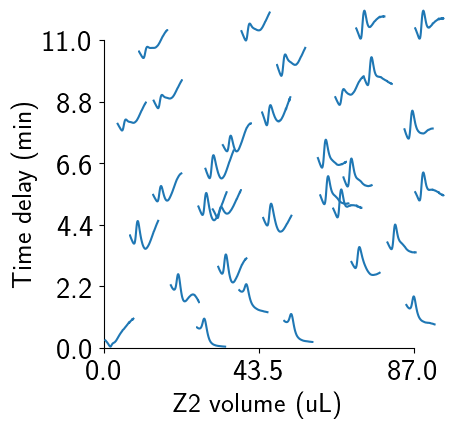

In [7]:
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(4,4))
    expt.plot(ax, test_function.bounds.cpu().numpy().T)
    ax.set_xlabel('Z2 volume (uL)')
    ax.set_ylabel('Time delay (min)') 
    plt.show()

### Plot acquisiton function at any given iteration

The acquisiton function is called on a dense grid of composition and represents the model predictive uncertainity at any given point in the composition.

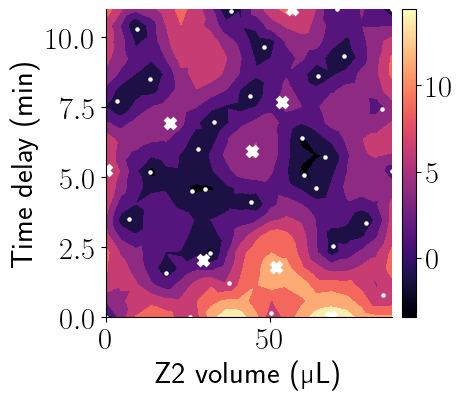

In [20]:
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colormaps 
from matplotlib.cm import ScalarMappable
from activephasemap.utils.visuals import get_twod_grid
from activephasemap.utils.settings import construct_acqf_by_model

acquisition = construct_acqf_by_model(gp_model, normalized_x, train_y, output_dim)

C_grid = get_twod_grid(20, test_function.bounds.cpu().numpy())
normalized_C_grid = normalize(torch.tensor(C_grid).to(train_x), test_function.bounds.to(train_x))
with torch.no_grad():
    acq_values = acquisition(normalized_C_grid.reshape(len(C_grid),1,2)).cpu().numpy()
cmap = colormaps["magma"]
norm = Normalize(vmin=min(acq_values), vmax = max(acq_values))
mappable = ScalarMappable(norm=norm, cmap=cmap)

with torch.no_grad(), plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(4,4))
    ax.tricontourf(C_grid[:,0], C_grid[:,1], acq_values, cmap=cmap, norm=norm)
    x_ = test_function.sim.comps
    ax.scatter(x_[:,0], x_[:,1], color='w', s=5)
    try:
        next_x = np.load("./data/comps_%d.npy"%(ITERATION))
        ax.scatter(next_x[:,0], next_x[:,1], marker='x', color='w', s=50, lw=4.0)
    except:
        pass
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax)
    # cbar.ax.set_ylabel('Acqusition value')
    ax.set_xlabel('Z2 volume (µL)')
    ax.set_ylabel('Time delay (min)') 
    
    plt.show()

### Plot phase map using the autophasemap

We first predict curves on a densly sampled grid, pass the (composition,spectra)-pairs to autophasemap algorithm that returns phase labels based on shape matching.

In [9]:
# from activephasemap.acquisitions.phaseboundary import PhaseBoundaryPenalty
# from activephasemap.utils.visuals import plot_autophasemap

# pbp = PhaseBoundaryPenalty(test_function, gp_model, np_model, max_iter_search=20, max_iter=50)
# with torch.no_grad(), plt.style.context(pyplot_style):
#     plot_autophasemap(pbp, './plots/autophasemap_%d.png'%ITERATION)